In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchinfo
import torchtext.transforms as T
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.schemas import NlpContext
from torchlake.text_classification.constants.misc import CHARCTERS
from torchlake.text_classification.models import CharCnn
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm

# setting


In [2]:
data_path = Path("../../data/covid-tweet")
artifacts_path = Path("../../artifacts/charcnn")

In [3]:
batch_size = 128
context = NlpContext(max_seq_len=27*34+96)

# data

In [4]:
train_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_train.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [5]:
test_data = pd.read_csv(
    data_path.joinpath("Corona_NLP_test.csv").as_posix(),
    encoding='latin-1',
    usecols=['OriginalTweet', 'Sentiment'],
)

In [6]:
train_data['Sentiment'].value_counts()

Sentiment
Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: count, dtype: int64

In [7]:
vocab = build_vocab_from_iterator(
    [*CHARCTERS],
    specials=context.special_tokens,
)

vocab.set_default_index(context.unk_idx)

In [8]:
label_encoder = LabelEncoder()
train_data['Sentiment'] = label_encoder.fit_transform(train_data['Sentiment'])

In [23]:
test_data['Sentiment'] = label_encoder.transform(test_data['Sentiment'])

In [9]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(context.max_seq_len - 2),
    T.AddToken(token=context.bos_idx, begin=True),
    T.AddToken(token=context.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(context.max_seq_len, context.padding_idx),
)

In [10]:
def collate_fn(batch: np.ndarray):
    text_placeholder, label_placeholder = [], []

    for text, label in batch:
        text = [*text]
        text = text_transform(text)
        text_placeholder.append(text)
        label_placeholder.append(label)

    return torch.stack(text_placeholder), torch.Tensor(label_placeholder)

In [26]:
train_iter = DataLoader(
    train_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
)

test_iter = DataLoader(
    test_data.to_numpy(),
    batch_size=batch_size,
    collate_fn=collate_fn,
)

In [12]:
for text, label in train_iter:
    print(text.shape, label.shape)
    break

torch.Size([128, 1014]) torch.Size([128])


# model


In [13]:
vocab_size = len(vocab)
label_size = train_data['Sentiment'].nunique()

In [14]:
device = torch.device(context.device)

In [35]:
model = CharCnn(vocab_size, label_size, context).to(device)

In [16]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
CharCnn                                  --
├─CharQuantization: 1-1                  --
├─Sequential: 1-2                        --
│    └─Conv1d: 2-1                       129,280
│    └─ReLU: 2-2                         --
│    └─MaxPool1d: 2-3                    --
│    └─Conv1d: 2-4                       459,008
│    └─ReLU: 2-5                         --
│    └─MaxPool1d: 2-6                    --
│    └─Conv1d: 2-7                       196,864
│    └─ReLU: 2-8                         --
│    └─Conv1d: 2-9                       196,864
│    └─ReLU: 2-10                        --
│    └─Conv1d: 2-11                      196,864
│    └─ReLU: 2-12                        --
│    └─Conv1d: 2-13                      196,864
│    └─ReLU: 2-14                        --
│    └─MaxPool1d: 2-15                   --
├─Sequential: 1-3                        --
│    └─Linear: 2-16                      8,913,920
│    └─Dropout: 2-17              

# train


In [17]:
epoches = 10

In [36]:
trainer = ClassificationTrainer(epoches, device)

In [37]:
criterion = trainer.get_criterion(label_size)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [38]:
training_loss = trainer.run(train_iter, model, optimizer, criterion)

100%|██████████| 321/321 [00:11<00:00, 28.70it/s]


epoch 1 : 0.012049588792583096


100%|██████████| 321/321 [00:10<00:00, 31.01it/s]


epoch 2 : 0.011772036114330418


100%|██████████| 321/321 [00:10<00:00, 30.89it/s]


epoch 3 : 0.01160585976313115


100%|██████████| 321/321 [00:10<00:00, 30.84it/s]


epoch 4 : 0.011270195939157426


100%|██████████| 321/321 [00:10<00:00, 30.93it/s]


epoch 5 : 0.010833582312820299


100%|██████████| 321/321 [00:10<00:00, 30.97it/s]


epoch 6 : 0.010353905430231881


100%|██████████| 321/321 [00:10<00:00, 31.05it/s]


epoch 7 : 0.010013180953157468


100%|██████████| 321/321 [00:10<00:00, 30.51it/s]


epoch 8 : 0.009644209624868687


100%|██████████| 321/321 [00:10<00:00, 29.67it/s]


epoch 9 : 0.009212228018395904


100%|██████████| 321/321 [00:10<00:00, 30.98it/s]

epoch 10 : 0.008696721200874754


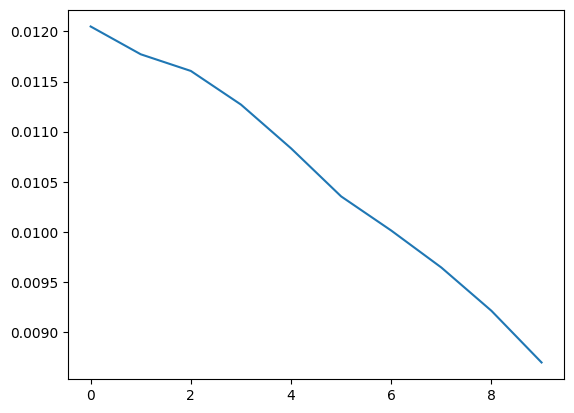

In [39]:
plt.plot(training_loss)

# inference


In [40]:
model.eval()
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(train_iter):
        text = text.to(device)
        label = label.to(device)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()

    print(running_hit / len(train_data))

100%|██████████| 321/321 [00:10<00:00, 30.13it/s]

0.5796097869135263


In [41]:
model.eval()
with torch.no_grad():
    running_hit = 0.0

    for text, label in tqdm(test_iter):
        text = text.to(device)
        label = label.to(device)

        output = model(text)

        pred = output.argmax(dim=1)
        pred = torch.sum(pred == label)
        running_hit += pred.item()

    print(running_hit / len(test_data))

100%|██████████| 30/30 [00:01<00:00, 29.33it/s]

0.4660347551342812


In [42]:
model_path = artifacts_path.joinpath("charcnn.pth")

In [43]:
torch.save(model.state_dict(), model_path)

In [44]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>